In [103]:
""""
Imports packages
"""
import tellurium as te
import pickle 
import math
import csv
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import ParameterSampler
from scipy.stats import lognorm
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import pandas as pd

In [ ]:
"""
Opens model, reads the file, and extracts the ground truth values for each species id
"""

model = te.readFromFile("C:/Users/bhavy/OneDrive/Desktop/SauroLab_2025/modeling/TopologyC_1.ant")
r = te.loada(model)

values = r.getSteadyStateValues()
species_ids = r.getFloatingSpeciesIds()

if len(values) != len(species_ids):
    print("values and species don't match")
else:
    for species_id, val in zip(species_ids, values): 
        if val < 0:
            print(f"negative concentrations")
        r[species_id] = val
    
    try:
        ground_truth = r.getScaledFluxControlCoefficientMatrix()
        
        with open('ground_truth.pkl', 'wb') as file: 
            pickle.dump(ground_truth, file)
    except RuntimeError as e:
        print(f"Error: {e}")


In [ ]:
"""
Extracts parameter names, removes equilibrium constants
"""

param_names = r.getGlobalParameterIds()
param_names = [param for param in param_names if 'Keq' not in param and 'e_' not in param] #remove e_vPGI
print(param_names)

['PGI_Vmax', 'PGI_KmG6P', 'PGI_KmF6P', 'PGI_KmPEP', 'PGI_KmPGN', 'PFK_Vmax', 'PFK_n', 'KdATPMg', 'KdADPMg', 'PFK_KirF6P', 'PFK_KmrATPMg', 'PFK_KmrFDP', 'PFK_KirFDP', 'PFK_KmrADP', 'PFK_KmrF6P', 'PFK_KirADP', 'PFK_KirATP', 'PFK_Wr', 'PFK_L0', 'PFK_KmtFDP', 'PFK_KitFDP', 'PFK_KmtADP', 'PFK_KmtF6P', 'PFK_KitF6P', 'PFK_KmtATPMg', 'PFK_KitADP', 'PFK_KitATP', 'PFK_Wt', 'PFK_KeftADP', 'PFK_KeftPEP', 'PFK_KefrADP', 'PFK_KefrPEP', 'FBA_Vmax', 'FBA_KmFDP', 'FBA_KmDAP', 'FBA_KmGAP', 'FBA_KmPEP', 'TPI_Vmax', 'TPI_KmDAP', 'TPI_KmGAP', 'GDH_Vmax', 'GDH_KmP', 'GDH_KmGAP', 'GDH_KmNAD', 'GDH_KmBPG', 'GDH_KmNADH', 'PGK_Vmax', 'PGK_KmADPMg', 'PGK_KmBPG', 'PGK_KmATPMg', 'PGK_KmPGA3', 'GPM_Vmax', 'GPM_KmPGA3', 'GPM_KmPGA2', 'ENO_Vmax', 'ENO_KmPGA2', 'ENO_KmPEP', 'PYK_Vmax', 'PYK_n', 'PYK_KirPEP', 'PYK_KmrADPMg', 'PYK_KmrPEP', 'PYK_KirATP', 'PYK_KirADP', 'PYK_KirPYR', 'PYK_KirPyrATP', 'PYK_L0', 'PYK_KmtPEP', 'PYK_KitPEP', 'PYK_KmtADPMg', 'PYK_KitATP', 'PYK_KitADP', 'PYK_KitPYR', 'PYK_KitPyrATP', 'PYK_KeftSU

In [83]:
"""
Saves the highest working value for the first n number of parameters and extracts the control coefficients for each value that works
"""


model = te.readFromFile("C:/Users/bhavy/OneDrive/Desktop/SauroLab_2025/modeling/TopologyC_1.ant")
r = te.loada(model)

param_names = param_names[:1]
plot_data = {}

for param in param_names:
    ranges_that_work = {}
    in_val = r[param]
    
    for j in range(1, 10):
        scale_factor = math.log(j + 1)  
        val = min(in_val * scale_factor, 1000)
        
        if val == 1000:
            break
        
        r[param] = val
        
        try:
            flux_control_coefficients = r.getScaledFluxControlCoefficientMatrix()
            ranges_that_work[val] = flux_control_coefficients
        except RuntimeError as e:
            print(f"Error: {e}")
            print(f"Param '{param}' failed for value {val}")
        
    if ranges_that_work:
        highest_working_value = max(ranges_that_work.keys())
        plot_data[param] = {highest_working_value, in_val}
        
        with open(f'{param}_test.pkl', 'wb') as file: 
            pickle.dump(ranges_that_work, file)
    else:
        print(f"All values failed for parameter {param}")
    
    print("\n\n\n\n")
    print(f"Acceptable range of values for parameter {param}:")
    print(ranges_that_work)
    
    r[param] = in_val
    
with open('parameters_that_work.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['Parameter', 'Parameter Value', 'Flux Control Coefficients'])
    writer.writeheader()
    
    for param in param_names:
        with open(f'{param}_test.pkl', 'rb') as file:
            ranges = pickle.load(file)
        
        for val, flux_control in ranges.items():
            flux_control_str = str(flux_control)  
            writer.writerow({'Parameter': param, 'Parameter Value': val, 'Flux Control Coefficients': flux_control_str})







Acceptable range of values for parameter PGI_Vmax:
{1.6112622100424263:                             vPGI,         vPFK,         vFBA,         vTPI,         vGDH,         vPGK,         vGPM,         vENO,         vPYK,         vZWF,         vPGL,         vGND,         vRPE,         vRPI, vX5P_GAP_TKT, vF6P_E4P_TKT, vS7P_R5P_TKT, vF6P_GAP_TAL, vS7P_E4P_TAL,         vFBP,         vPPC,         vPCK,         vPPS,         vMAD,         vPDH,         vGLT,       vACN_1,       vACN_2,         vICD,         vLPD,          vSK,         vSDH,        vFUMA,         vMQO,         vMDH,        vACEA,        vACEB,      vACEK_1,      vACEK_2,         vEDD,         vEDA,    vNADH_req,     vPNT_req,         vADK,     vATP_syn,         vCYA,         vDOS,         vACK,         vACS,         vPTA,       vPTS_0,       vPTS_1,       vPTS_2,       vPTS_3,       vPTS_4,    vGLC_feed,       vCYTBO,         vSQR,       vNDHII,      vGROWTH, vATP_MAINTENANCE, vXCH_GLC,         vPIT,       vXCH_P,    vXCH

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


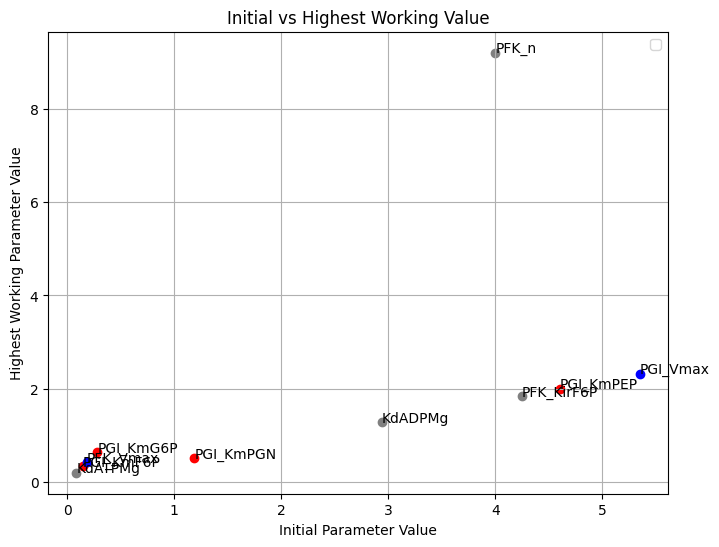

In [ ]:
"""
Graphs the highest working value for each parameter
"""


import matplotlib.pyplot as plt
import numpy as np

initial_values = []
highest_working_values = []
params_to_plot = []  

for param in plot_data:
    highest_working_value, in_val = plot_data[param]
    
    initial_values.append(in_val)
    
    highest_working_values.append(highest_working_value)
    params_to_plot.append(param)

initial_values = np.array(initial_values)
highest_working_values = np.array(highest_working_values)

plt.figure(figsize=(8, 6))

for i, param in enumerate(params_to_plot):
    if 'Vmax' in param:
        color = 'blue'
    elif 'Km' in param:
        color = 'red'
    elif 'PGI' in param:
        color = 'purple'
    elif 'PYK' in param:
        color = 'black'
    else:
        color = 'gray' 
    
    plt.scatter(initial_values[i], highest_working_values[i], color=color, marker='o')
    plt.annotate(param, (initial_values[i], highest_working_values[i]))

    #plt.xlim(0, 0.5)
    #plt.ylim(0, 2)
    
plt.title('Initial vs Highest Working Value')
plt.xlabel('Initial Parameter Value')
plt.ylabel('Highest Working Parameter Value')
plt.grid(True)

plt.legend()

plt.show()


In [75]:
"""
Grid parameter search for the TopologyC_1.ant model (can adjust number of parameters to do search over)

"""


model_text = te.readFromFile("C:/Users/bhavy/OneDrive/Desktop/SauroLab_2025/modeling/TopologyC_1.ant")

names = ['PGI_Vmax', 'PGI_KmG6P', 'PGI_KmF6P']

params_that_worked = []
params_that_failed = []

def run_and_save_grid_search(param_set): 
    print(f"Trying: {param_set}")
    
    for param, value in param_set.items():
        if param in r.getGlobalParameterIds(): 
            r[param] = value 
            print(f"{param}: {value}")
        else: 
            print(f"{param} not found")
 
    try:
        fcc = r.getScaledFluxControlCoefficientMatrix()

        if (
            np.isnan(fcc).any()
            or np.isinf(fcc).any()
            or not np.all(np.isfinite(fcc))
            or np.abs(fcc).max() < 1e-6   # suspiciously small everywhere
            or np.abs(fcc).max() > 1e3    # unreasonably large values
            or np.allclose(fcc, 0, atol=1e-5)  # entirely zero or negligible
        ):
            params_that_failed.append(param_set.copy())
            print("failed")
        else: 
            params_that_worked.append(param_set.copy())
    except RuntimeError as e:
        print(f"Error: {e}")
        print(f"Failed param set: {param_set}")
        params_that_failed.append(param_set.copy())

param_dists = {name: lognorm(s=0.5, scale=np.exp(2)) for name in names}

n_samples = 50
grid = list(ParameterSampler(param_dists, n_iter=n_samples, random_state=42))

for param_set in grid:
    run_and_save_grid_search(param_set)

print(f"successful parameter sets: {len(params_that_worked)}")
print(params_that_worked)

Trying: {'PGI_KmF6P': 9.472161009871938, 'PGI_KmG6P': 6.895491894221446, 'PGI_Vmax': 10.21486762243323}
PGI_KmF6P: 9.472161009871938
PGI_KmG6P: 6.895491894221446
PGI_Vmax: 10.21486762243323
Trying: {'PGI_KmF6P': 15.823796715499308, 'PGI_KmG6P': 6.572690835415946, 'PGI_Vmax': 6.572744790114265}
PGI_KmF6P: 15.823796715499308
PGI_KmG6P: 6.572690835415946
PGI_Vmax: 6.572744790114265
Trying: {'PGI_KmF6P': 16.274612979553005, 'PGI_KmG6P': 10.84514337507538, 'PGI_Vmax': 5.843107766131876}
PGI_KmF6P: 16.274612979553005
PGI_KmG6P: 10.84514337507538
PGI_Vmax: 5.843107766131876
Trying: {'PGI_KmF6P': 9.691798591077472, 'PGI_KmG6P': 5.860829541737841, 'PGI_Vmax': 5.854058159457974}
PGI_KmF6P: 9.691798591077472
PGI_KmG6P: 5.860829541737841
PGI_Vmax: 5.854058159457974
Trying: {'PGI_KmF6P': 8.339315475992548, 'PGI_KmG6P': 2.8387388245260103, 'PGI_Vmax': 3.1190893485212103}
PGI_KmF6P: 8.339315475992548
PGI_KmG6P: 2.8387388245260103
PGI_Vmax: 3.1190893485212103
Trying: {'PGI_KmF6P': 5.578144729637362, '

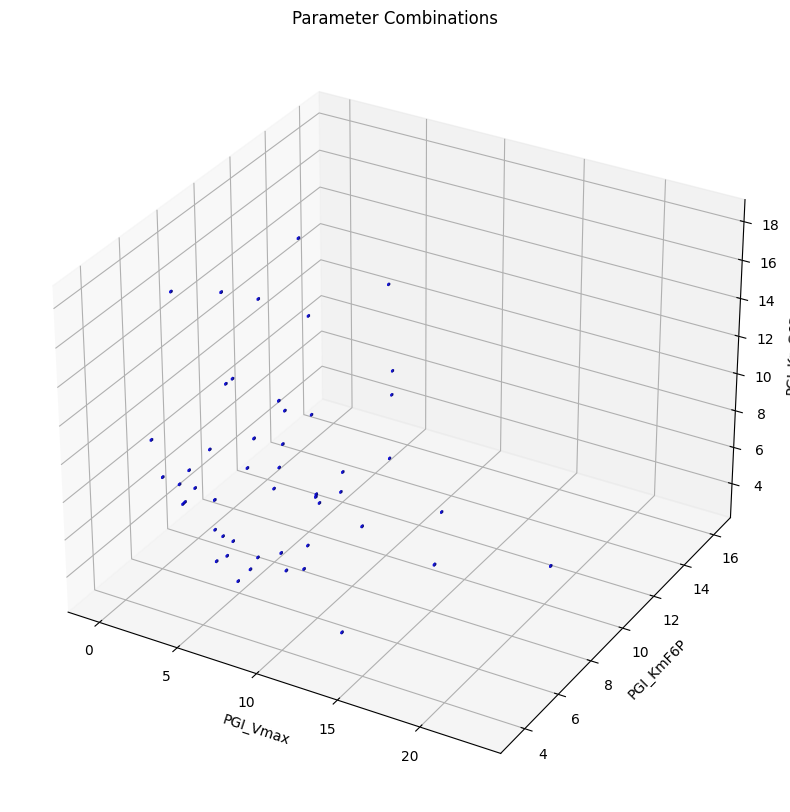

"\nSuccessful parameter combinations will show up as blue points. \nUnsuccessful parameter combinations will show up as red points.\nThe x,y,z axes are the differences from the standard value for each parameter.  \n\nx='PGI_Vmax'\ny='PGI_KmF6P'\nz='PGI_KmG6P'\n"

In [76]:
"""
Visualization of parameter search
"""

x='PGI_Vmax'
y='PGI_KmF6P'
z='PGI_KmG6P'
r = te.loada(model_text)

x_vals, y_vals, z_vals = [], [], []

for p in params_that_worked:
    x_vals.append(p[x] - r[x])
    y_vals.append(p[y] - r[y])
    z_vals.append(p[z] - r[z])

x_vals_failed, y_vals_failed, z_vals_failed = [], [], []

for p in params_that_failed: 
    x_vals_failed.append(p[x] - r[x])
    y_vals_failed.append(p[y] - r[y])
    z_vals_failed.append(p[z] - r[z])


fig = plt.figure(figsize=(8, 24))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x_vals, y_vals, z_vals, 0.1, 0.1, 0.1, color='blue', alpha=0.8) 
#ax.bar3d(x_vals_failed, y_vals_failed, z_vals_failed, 0.1, 0.1, 0.1, color='red', alpha=0.8) 

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.set_title('Parameter Combinations')

plt.tight_layout()
plt.show()


"""
Successful parameter combinations will show up as blue points. 
Unsuccessful parameter combinations will show up as red points.
The x,y,z axes are the differences from the standard value for each parameter.  

x='PGI_Vmax'
y='PGI_KmF6P'
z='PGI_KmG6P'
"""

In [ ]:
"""
Testing different correlation between parameters that work
Tested following correlation: 
1. Pearson correlation coefficient (linear relationship)
- Determine if there is any correlation between each of the variables pairwise
2. Test if there is a polynomial relationship pairwise between the variables next
- Try different polynomial degrees and take max r-squared from those
Not strong correlation linearly 
"""
#Data Extraction
x = 'PGI_Vmax'
param1 = np.array([p[x] for p in params_that_worked])

y = 'PGI_KmF6P'
param2 = np.array([p[y] for p in params_that_worked])

z = 'PGI_KmG6P'
param3 = np.array([p[z] for p in params_that_worked])

data = pd.DataFrame({
    'x': param1,
    'y': param2,
    'z': param3
})

correlation_matrix = data.corr()
print(correlation_matrix)

#not a linear relationship, will try polynomial relationship next

          x         y         z
x  1.000000 -0.230964 -0.044787
y -0.230964  1.000000 -0.112463
z -0.044787 -0.112463  1.000000


In [ ]:
"""
FBA on this network 
"""